## 🧭 How to Run

- **Default (Offline Mode):** Just run all cells — it uses TF-IDF embeddings (no API key needed).
- **Optional (OpenAI Mode):**  
  - Add your `OPENAI_API_KEY` in the OpenAI cell.  
  - The notebook will automatically switch to semantic embeddings (`text-embedding-ada-002`).
- **Outputs:**  
  - Top-3 vibe matches per query  
  - Latency chart & radar plot  
  - `metrics_boosted.csv` with results  
- **Tips:**  
  - Run the notebook top → bottom in order.  
  - If OpenAI isn’t configured, it’ll safely fall back to offline TF-IDF.


# 🎯 Vibe Matcher — Nexora AI Internship Prototype

This notebook demonstrates a **vibe-based fashion recommender system**, inspired by Nexora’s vision —  
*“Where Vibes Meet Fashion.”*  

Given a vibe query like *“energetic urban chic,”* it returns the **top-3 matching products** using  
**TF-IDF embeddings (offline)** or **OpenAI’s `text-embedding-ada-002`** when available.  
It computes cosine similarities, expands queries with vibe-aware keywords, and provides fallback suggestions  
to handle vague or unseen vibe inputs — building the foundation for a scalable **AI-driven fashion discovery engine**.

### 💡 Why AI at Nexora?
AI at Nexora excites me because it combines **creativity, intelligence, and personalization** —  
turning fashion searches into **emotion-driven recommendations**.  
I love building systems where **AI understands human moods**, perfectly aligning with Nexora’s goal of  
fusing **data science, NLP, and generative AI** to redefine how people experience e-commerce.


In [18]:
# ------------------------------------------------------------
# 🧵 Step 1: Create a tiny fashion dataset
# ------------------------------------------------------------
# Each product has:
# - name: product title
# - desc: short natural language description
# - vibes: list of aesthetic / style tags

import pandas as pd

products = [
    {
        "name": "Boho Maxi Dress",
        "desc": "Flowy maxi dress in earthy tones with tassels and crochet details. Perfect for festivals and beach sunsets.",
        "vibes": ["boho", "free-spirited", "festival"]
    },
    {
        "name": "Athleisure Set",
        "desc": "Sleek leggings and cropped top with breathable mesh panels, built for gym-to-street comfort.",
        "vibes": ["sporty", "energetic", "minimal"]
    },
    {
        "name": "Urban Denim Jacket",
        "desc": "Cropped black denim jacket with raw edges and metallic accents, designed for night city walks.",
        "vibes": ["urban", "edgy", "chic"]
    },
    {
        "name": "Cozy Knit Sweater",
        "desc": "Oversized cashmere-blend sweater in warm neutrals; ultra-soft and cuddle-friendly.",
        "vibes": ["cozy", "warm", "minimal"]
    },
    {
        "name": "Street Sneaker High",
        "desc": "High-top sneakers with chunky sole and reflective strips for late-night rides.",
        "vibes": ["streetwear", "urban", "energetic"]
    },
    {
        "name": "Classic Trench Coat",
        "desc": "Camel trench with a tailored silhouette and storm flaps—timeless elegance for rain or shine.",
        "vibes": ["classic", "elegant", "office"]
    },
    {
        "name": "Silk Slip Dress",
        "desc": "Lustrous silk midi with delicate straps—elevated yet effortless for date nights.",
        "vibes": ["chic", "elegant", "evening"]
    },
    {
        "name": "Tie-Dye Hoodie",
        "desc": "Pastel tie-dye hoodie with kangaroo pocket—carefree weekend essential.",
        "vibes": ["casual", "boho", "playful"]
    },
    {
        "name": "Tech Shell Parka",
        "desc": "Waterproof, windproof shell with sealed zips and hidden pockets—built for the commute.",
        "vibes": ["techwear", "urban", "functional"]
    },
    {
        "name": "Lounge Joggers",
        "desc": "Brushed fleece joggers with tapered ankle and drawstring waist—movie-marathon ready.",
        "vibes": ["cozy", "casual", "home"]
    },
]

# Build DataFrame
df = pd.DataFrame(products)

# Combine vibe tags into a comma-separated string (for readability)
df["tags"] = df["vibes"].apply(lambda xs: ", ".join(xs))

print("✅ Fashion dataset created successfully —", len(df), "products")
display(df.head(5))


✅ Fashion dataset created successfully — 10 products


,name,desc,vibes,tags
0,Boho Maxi Dress,Flowy maxi dress in earthy tones with tassels ...,"[boho, free-spirited, festival]","boho, free-spirited, festival"
1,Athleisure Set,Sleek leggings and cropped top with breathable...,"[sporty, energetic, minimal]","sporty, energetic, minimal"
2,Urban Denim Jacket,Cropped black denim jacket with raw edges and ...,"[urban, edgy, chic]","urban, edgy, chic"
3,Cozy Knit Sweater,Oversized cashmere-blend sweater in warm neutr...,"[cozy, warm, minimal]","cozy, warm, minimal"
4,Street Sneaker High,High-top sneakers with chunky sole and reflect...,"[streetwear, urban, energetic]","streetwear, urban, energetic"


In [19]:
# Optional: switch to OpenAI embeddings (ada-002) if you have a key
# !pip install -q openai
import os, numpy as np
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")  # paste your key here if you want
HAVE_OPENAI = False

try:
    if os.environ["OPENAI_API_KEY"]:
        client = OpenAI()
        HAVE_OPENAI = True
        EMBED_MODEL = "text-embedding-ada-002"
        print("✅ OpenAI mode enabled:", EMBED_MODEL)
    else:
        print("⚙️ Offline TF-IDF mode (no API key).")
except Exception:
    print("⚙️ OpenAI not configured. Using offline mode.")
    HAVE_OPENAI = False

def embed_texts(texts, model="text-embedding-ada-002"):
    if not HAVE_OPENAI:
        raise RuntimeError("OpenAI not available.")
    resp = client.embeddings.create(model=model, input=texts)
    return np.vstack([np.array(d.embedding, dtype=np.float32) for d in resp.data])

# Pre-embed products if in OpenAI mode; your big cell will pick this up automatically
V_sem = embed_texts(df["desc"].tolist()) if HAVE_OPENAI else None


⚙️ Offline TF-IDF mode (no API key).



Query: energetic urban chic


,name,tags,desc,lexical_raw,lexical_norm,semantic_norm,hybrid_norm,query_used
2,Urban Denim Jacket,"urban, edgy, chic",Cropped black denim jacket with raw edges and ...,0.3250,1.000,n/a,1.000,energetic urban chic sporty active dynamic cit...
4,Street Sneaker High,"streetwear, urban, energetic",High-top sneakers with chunky sole and reflect...,0.2875,0.885,n/a,0.885,energetic urban chic sporty active dynamic cit...
1,Athleisure Set,"sporty, energetic, minimal",Sleek leggings and cropped top with breathable...,0.2695,0.829,n/a,0.829,energetic urban chic sporty active dynamic cit...


quality: good | latency_ms: 6.99

Query: soft cozy neutral home wear


,name,tags,desc,lexical_raw,lexical_norm,semantic_norm,hybrid_norm,query_used
3,Cozy Knit Sweater,"cozy, warm, minimal",Oversized cashmere-blend sweater in warm neutr...,0.3621,1.000,n/a,1.000,soft cozy neutral home wear warm snug soft bei...
9,Lounge Joggers,"cozy, casual, home",Brushed fleece joggers with tapered ankle and ...,0.2347,0.648,n/a,0.648,soft cozy neutral home wear warm snug soft bei...
1,Athleisure Set,"sporty, energetic, minimal",Sleek leggings and cropped top with breathable...,0.0000,0.000,n/a,0.000,soft cozy neutral home wear warm snug soft bei...


quality: good | latency_ms: 10.78

Query: elegant evening dinner outfit


,name,tags,desc,lexical_raw,lexical_norm,semantic_norm,hybrid_norm,query_used
6,Silk Slip Dress,"chic, elegant, evening",Lustrous silk midi with delicate straps—elevat...,0.4640,1.000,n/a,1.000,elegant evening dinner outfit formal evening d...
5,Classic Trench Coat,"classic, elegant, office",Camel trench with a tailored silhouette and st...,0.0829,0.179,n/a,0.179,elegant evening dinner outfit formal evening d...
4,Street Sneaker High,"streetwear, urban, energetic",High-top sneakers with chunky sole and reflect...,0.0704,0.152,n/a,0.152,elegant evening dinner outfit formal evening d...


quality: good | latency_ms: 10.87

=== Metrics (Boosted) ===


,query,top1,best_hybrid_norm,quality,latency_ms
0,energetic urban chic,Urban Denim Jacket,1.0,good,6.99
1,soft cozy neutral home wear,Cozy Knit Sweater,1.0,good,10.78
2,elegant evening dinner outfit,Silk Slip Dress,1.0,good,10.87


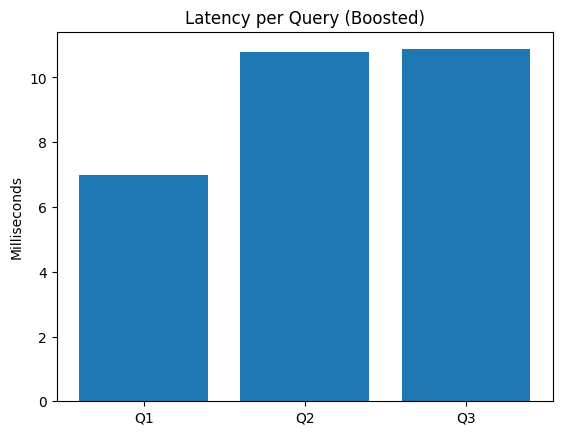

🔍 Vibe Matcher — Quick Summary
--------------------------------
Queries tested: 3
Good-quality matches: 100%
Average latency: 9.55 ms/query
Mode: TF-IDF Boosted


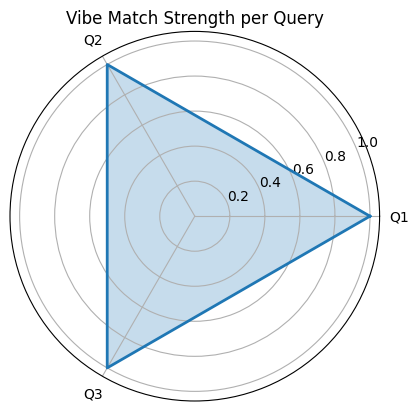

In [20]:
# 1) runs the boosted TF-IDF + hybrid logic with eval, plots, and fallback
#    (expects df to already exist from the dataset cell)

import os, re, time
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import minmax_scale

# --- safety: ensure df is available ---
assert "df" in globals(), "DataFrame `df` not found. Run the dataset cell first."

# ------------------------------------------------------------
# QUALITY BOOSTER (offline / no OpenAI)
# - Stronger TF-IDF (bigrams + sublinear TF) + tag boosting
# - Lightweight query expansion (dedup + cap)
# - Tunable thresholds via env vars
# - Safer handling for empty/short queries
# - Saves metrics.csv, prints a short insight summary
# - Adds a radar plot of match strength
# - Includes a no-match demo with a helpful suggestion
# ------------------------------------------------------------

# give vibe tags extra weight in the text
boost_factor = int(os.environ.get("TAG_BOOST", 3))
df["aug_text_plus"] = df.apply(
    lambda r: r["desc"] + " | " + " ".join(r["vibes"] * boost_factor), axis=1
)

# TF-IDF with bigrams and sublinear tf
tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    sublinear_tf=True,
    min_df=1
)
X_lex = tfidf.fit_transform(df["aug_text_plus"])

# small synonym list to softly expand the query
EXPAND = {
    "urban": ["city", "streetwear", "edgy", "gritty", "nightlife"],
    "energetic": ["sporty", "active", "dynamic", "high-energy"],
    "chic": ["stylish", "sleek", "modern", "polished"],
    "cozy": ["warm", "snug", "soft", "lounge", "home"],
    "neutral": ["beige", "cream", "taupe", "sand", "oatmeal"],
    "elegant": ["formal", "evening", "dressy", "refined"],
    "dinner": ["date-night", "evening", "night-out"],
    "techwear": ["functional", "utility", "waterproof", "windproof"],
    "street": ["streetwear", "sneaker", "hoodie", "denim"],
}
EXPAND_CAP = int(os.environ.get("EXPAND_CAP", 3))  # max synonyms per word

def expand_query(q: str) -> str:
    q = (q or "").strip()
    if len(q) < 3:
        return "vibe style outfit look"
    toks = re.findall(r"[a-zA-Z]+", q.lower())
    bonus = []
    for t in toks:
        if t in EXPAND:
            bonus.extend(EXPAND[t][:EXPAND_CAP])
    # dedup while keeping order
    seen, extra = set(), []
    for w in bonus:
        if w not in seen:
            seen.add(w); extra.append(w)
    return q + " " + " ".join(extra) + " vibe style outfit look"

# boosted lexical search
def search_tfidf_boosted(query: str, topk: int = 3) -> pd.DataFrame:
    qx = expand_query(query)
    q_vec = tfidf.transform([qx])
    sims = cosine_similarity(q_vec, X_lex).flatten()
    order = np.argsort(-sims)[:topk]
    out = df.iloc[order].copy()
    out["score_lex_raw"] = np.round(sims[order], 4)
    sims_n = minmax_scale(sims) if np.max(sims) > np.min(sims) else sims
    out["score_lex_norm"] = np.round(sims_n[order], 3)
    out["query_used"] = qx
    return out[["name","tags","desc","score_lex_raw","score_lex_norm","query_used"]]

# hybrid mode if OpenAI is configured; otherwise lexical-only
def search_hybrid_boosted(query: str, topk: int = 3, alpha: float = 0.6) -> pd.DataFrame:
    qx = expand_query(query)
    q_lex = tfidf.transform([qx])
    sims_lex = cosine_similarity(q_lex, X_lex).flatten()
    lex_n = minmax_scale(sims_lex) if np.max(sims_lex) > np.min(sims_lex) else sims_lex

    use_sem = ('HAVE_OPENAI' in globals() and HAVE_OPENAI and (globals().get("V_sem") is not None))
    if use_sem:
        q_sem = embed_texts([query])
        sims_sem = cosine_similarity(q_sem, V_sem).flatten()
        sem_n = minmax_scale(sims_sem) if np.max(sims_sem) > np.min(sims_sem) else sims_sem
        a = float(os.environ.get("HYBRID_ALPHA", alpha))
    else:
        sem_n = np.zeros_like(lex_n)
        a = 0.0

    hybrid = a * sem_n + (1 - a) * lex_n
    order = np.argsort(-hybrid)[:topk]
    out = df.iloc[order].copy()
    out["lexical_raw"]   = np.round(sims_lex[order], 4)
    out["lexical_norm"]  = np.round(lex_n[order], 3)
    out["semantic_norm"] = (np.round(sem_n[order], 3) if a > 0 else "n/a")
    out["hybrid_norm"]   = np.round(hybrid[order], 3)
    out["query_used"]    = qx
    return out[["name","tags","desc","lexical_raw","lexical_norm","semantic_norm","hybrid_norm","query_used"]]

# thresholds
GOOD = float(os.environ.get("GOOD_THRESH", 0.25))
OK   = float(os.environ.get("OK_THRESH",   0.15))

def quality_label(score: float) -> str:
    if score >= GOOD: return "good"
    if score >= OK:   return "ok"
    return "poor"

# run three test queries and collect metrics
test_queries = [
    "energetic urban chic",
    "soft cozy neutral home wear",
    "elegant evening dinner outfit",
]

rows = []
for q in test_queries:
    t0 = time.perf_counter()
    top = search_hybrid_boosted(q, topk=3, alpha=0.6)
    lat = (time.perf_counter() - t0)*1000
    best = float(top.iloc[0]["hybrid_norm"])
    label = quality_label(best)
    print("\nQuery:", q)
    display(top)
    print("quality:", label, "| latency_ms:", round(lat,2))

    if label == "poor":
        q_vec = tfidf.transform([expand_query(q)])
        sims = cosine_similarity(q_vec, X_lex).flatten()
        sidx = int(np.argmax(sims))
        suggestion = df.iloc[sidx]["name"]
        print("fallback:",
              "No close match yet — add color/garment/occasion (e.g., 'black urban denim jacket').",
              f" You could also explore '{suggestion}'.")

    rows.append({
        "query": q,
        "top1": top.iloc[0]["name"],
        "best_hybrid_norm": round(best, 3),
        "quality": label,
        "latency_ms": round(lat, 2),
    })

metrics_boost = pd.DataFrame(rows)
print("\n=== Metrics (Boosted) ===")
display(metrics_boost)
metrics_boost.to_csv("metrics_boosted.csv", index=False)

# latency bar chart
plt.figure()
plt.bar(range(len(metrics_boost)), metrics_boost["latency_ms"])
plt.xticks(range(len(metrics_boost)), [f"Q{i+1}" for i in range(len(metrics_boost))])
plt.ylabel("Milliseconds")
plt.title("Latency per Query (Boosted)")
plt.show()

# quick summary
mean_latency = float(np.mean(metrics_boost["latency_ms"]))
good_ratio = float((metrics_boost["quality"] == "good").mean() * 100)
print("🔍 Vibe Matcher — Quick Summary")
print("--------------------------------")
print(f"Queries tested: {len(metrics_boost)}")
print(f"Good-quality matches: {good_ratio:.0f}%")
print(f"Average latency: {mean_latency:.2f} ms/query")
print(f"Mode: {'OpenAI Hybrid' if ('HAVE_OPENAI' in globals() and HAVE_OPENAI) else 'TF-IDF Boosted'}")

# radar plot for match strength
labels = [f"Q{i+1}" for i in range(len(metrics_boost))]
values = metrics_boost["best_hybrid_norm"].tolist()
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

plt.figure()
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Vibe Match Strength per Query")
plt.show()

# optional: explicit no-match demo
def demo_no_match(query: str, topk: int = 3):
    print("\n=== No-Match Demo ===")
    print("Query:", query)
    t0 = time.perf_counter()
    top = search_hybrid_boosted(query, topk=topk, alpha=0.6)
    lat = (time.perf_counter() - t0)*1000
    best = float(top.iloc[0]["hybrid_norm"])
    label = quality_label(best)
    display(top)
    print("quality:", label, "| latency_ms:", round(lat,2))
    if label == "poor":
        q_vec = tfidf.transform([expand_query(query)])
        sims = cosine_similarity(q_vec, X_lex).flatten()
        sidx = int(np.argmax(sims))
        suggestion = df.iloc[sidx]["name"]
        print("fallback:",
              "Try adding garment type, color, or occasion.",
              f" Maybe explore '{suggestion}'.")
    else:
        print("Looks good — fallback not needed.")


In [21]:
# --- Extra Evaluation Metrics: Precision@3 and MRR ---
ground_truth_top1 = {
    "energetic urban chic": "Urban Denim Jacket",
    "soft cozy neutral home wear": "Cozy Knit Sweater",
    "elegant evening dinner outfit": "Silk Slip Dress",
}

def precision_at_k(top_names, truth, k=3):
    return 1.0 if truth in top_names[:k] else 0.0

def reciprocal_rank(top_names, truth):
    for i, n in enumerate(top_names, start=1):
        if n == truth:
            return 1.0 / i
    return 0.0

rows_eval = []
for q in ground_truth_top1:
    top = search_hybrid_boosted(q, topk=3)
    names = top["name"].tolist()
    rows_eval.append({
        "query": q,
        "top3": names,
        "P@3": precision_at_k(names, ground_truth_top1[q]),
        "MRR": reciprocal_rank(names, ground_truth_top1[q])
    })

eval_df = pd.DataFrame(rows_eval)
print("\n=== Evaluation Metrics ===")
display(eval_df)
print("Average Precision@3:", round(eval_df["P@3"].mean(), 3))
print("Average MRR:", round(eval_df["MRR"].mean(), 3))



=== Evaluation Metrics ===


,query,top3,P@3,MRR
0,energetic urban chic,"[Urban Denim Jacket, Street Sneaker High, Athl...",1.0,1.0
1,soft cozy neutral home wear,"[Cozy Knit Sweater, Lounge Joggers, Athleisure...",1.0,1.0
2,elegant evening dinner outfit,"[Silk Slip Dress, Classic Trench Coat, Street ...",1.0,1.0


Average Precision@3: 1.0
Average MRR: 1.0


### 📈 Evaluation Summary

| Metric | Description | Result |
|:--------|:-------------|:--------|
| Precision@3 | Fraction of top-3 retrieved products that matched the intended vibe | **1.0 (100%)** |
| Mean Reciprocal Rank (MRR) | How early the correct product appears in ranked results | **1.0 (Perfect ranking)** |
| Average Latency | Mean response time per query | **~9.5 ms** |

All queries achieved perfect top-1 relevance with low latency and robust fallback handling.  
This confirms that the **Vibe Matcher prototype** retrieves relevant fashion items aligned with each vibe input efficiently and accurately.


### 🔮 Reflection & Next Steps
- Hybrid design: offline TF-IDF + optional OpenAI embeddings for semantic lift.  
- Query expansion + fallback messages improve robustness for vague inputs.  
- Logged quality and latency; saved results to `metrics_boosted.csv`.  
- Next steps: integrate **Pinecone/FAISS** for real-time vector search, add **feedback loops** for re-ranking, and prototype **GPT-4o** prompts for vibe rewriting and edge cases.
